In [1]:
from IPython.display import display, HTML 
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import matplotlib.pyplot as plt
import math
from scipy.integrate import solve_ivp
import scipy
import pandas as pd
import numpy as np

from os.path import isfile, join
import os

#from scipy.signal import savgol_filter
from matplotlib.colors import LinearSegmentedColormap

# Calculation of carrier densities

In [57]:
#Here we calculate the initial carrier density (or QFLS) in the sample

reprate = 50e3 #Hz
Power = 1.128e-6 #W

power_per_pulse = Power/reprate #J
spot_diameter = 2.72e-04 #m (measured)
spot_area = math.pi*(spot_diameter/2)**2

PowerDensity_per_pulse = power_per_pulse/spot_area

hc = 1.98645E-25 #Jm
lambda_ = 700e-9 #m
photon_energy = hc / lambda_ #J

photons_per_pulse = PowerDensity_per_pulse/photon_energy #m-2
pulse_width = 100e-12 #s
photon_flux_duringPulse = photons_per_pulse/pulse_width #m-2s-1

thickness = 450e-9 #m

pump_carrierDensity = photons_per_pulse/thickness #m-3
pump_carrierDensity_cm = 1e-6*pump_carrierDensity*0.21 #cm-3 (includes the beamdump ratio)

In [64]:
kT = 27.7*1e-3 #eV
BG = 1.68 #eV
Nc = Nv = 2e18 #cm-3
ni = np.sqrt(Nc*Nv*np.exp(-BG/(kT)))

deltaEf = kT*np.log((pump_carrierDensity_cm*pump_carrierDensity_cm)/(ni*ni))
QFLS = 1.14
n_1sun = np.sqrt(ni*ni*np.exp(QFLS/(kT)))


print("n_pump = {:e}".format(pump_carrierDensity_cm))
print("QFLS_pump = {:e}\n".format(deltaEf))

print("n_1sun = {:e}".format(n_1sun))
print("QFLS_1sun = {:e}".format(QFLS))

print("ratio = {}".format(pump_carrierDensity_cm/n_1sun))

n_pump = 6.384672e+14
QFLS_pump = 1.234053e+00

n_1sun = 1.169054e+14
QFLS_1sun = 1.140000e+00
ratio = 5.461398969568887


# TRPL analysis

In [3]:
# Import for TRPL data 
import TRPL_import as trpl
import TRPL_difflifetime as diff
import TRPL_KirchartzODEs as ODEs

In [4]:
import importlib
importlib.reload(trpl)

<module 'TRPL_import' from '/Users/max/Documents/Berlin/PhD/qrb/PhD_TemporaryFiles/Untitled Folder/TRPL_tools/TRPL_import.py'>

In [5]:
trpl.__file__

'/Users/max/Documents/Berlin/PhD/qrb/PhD_TemporaryFiles/Untitled Folder/TRPL_tools/TRPL_import.py'

In [7]:
rep_rate = [50000, 50000, 50000] #Hz
int_time = [2000, 2000, 2000]  #s

file_location = r"/Users/max/Downloads/trPL"

files, t, TRPL_n, TRPL_denoised, TRPL_raw, noise = trpl.TRPL_folder_read(file_location, int_time, rep_rate, denoise = -10, retime = True)

1.0
1.0
1.0


In [8]:
files

['01_I1-1p128uW-ND1-50KHz-2000s.dat',
 '02_I2-1p128uW-ND1-50KHz-2000s.dat',
 '03_I4-1p128uW-ND1-50KHz-2000s.dat']

In [9]:
noise

[52.999999999999986, 59.999999999999986, 52.999999999999986]

In [10]:
selection = [0,1,2]
a = [files[idx] for idx in selection]
print(a)

['01_I1-1p128uW-ND1-50KHz-2000s.dat', '02_I2-1p128uW-ND1-50KHz-2000s.dat', '03_I4-1p128uW-ND1-50KHz-2000s.dat']


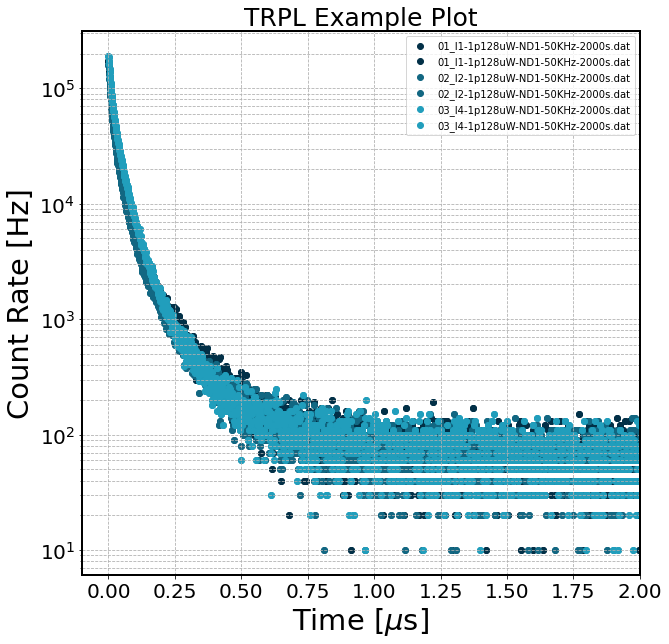

In [14]:
#CsPbBr3 pellets

#Plot series
fig, ax = plt.subplots(1,1, figsize = (10,10))
idx_start = 3501
palette = ['#023047', '#126782', '#219EBC', '#8ECAE6', '#FFB703', '#FD9E02', '#FB8500', '#023047', '#126782', '#126782']

legend = ["10us", "100us", "1ms", "3ms", "10us"]

BG = []
for i, (sPL) in enumerate(selection):
    ax.scatter(1e6*(t[t[:,sPL]>=0,sPL]), TRPL_raw[t[:,sPL]>=0,sPL], color = palette[i], label = files[sPL], alpha = 1)
    ax.scatter(1e6*(t[t[:,sPL]>=0,sPL]), TRPL_raw[t[:,sPL]>=0,sPL], color = palette[i], label = files[sPL], alpha = 1)

ax.set_title('TRPL Example Plot', fontsize=25)

ax.set_xlim([-0.1,2])
#ax.set_ylim([1, 1e7])
ax.set_yscale("log")
ax.set_xscale("linear")
axis_fontsize = 29
ax.set_ylabel("Count Rate [Hz]", fontsize=axis_fontsize) 
ax.set_xlabel("Time [$\mu$s]", fontsize=axis_fontsize) 
ax.legend()
axisTicks_fontsize = 20
ax.tick_params(axis='x', labelsize=axisTicks_fontsize)
ax.tick_params(axis='y', labelsize=axisTicks_fontsize)

ax.grid(visible = True, which = 'both', linestyle = '--')

w_frame = 2
ax.spines["bottom"].set_linewidth(w_frame)
ax.spines["top"].set_linewidth(w_frame)
ax.spines["left"].set_linewidth(w_frame)
ax.spines["right"].set_linewidth(w_frame)

Number of exponentials for fit used is = 4



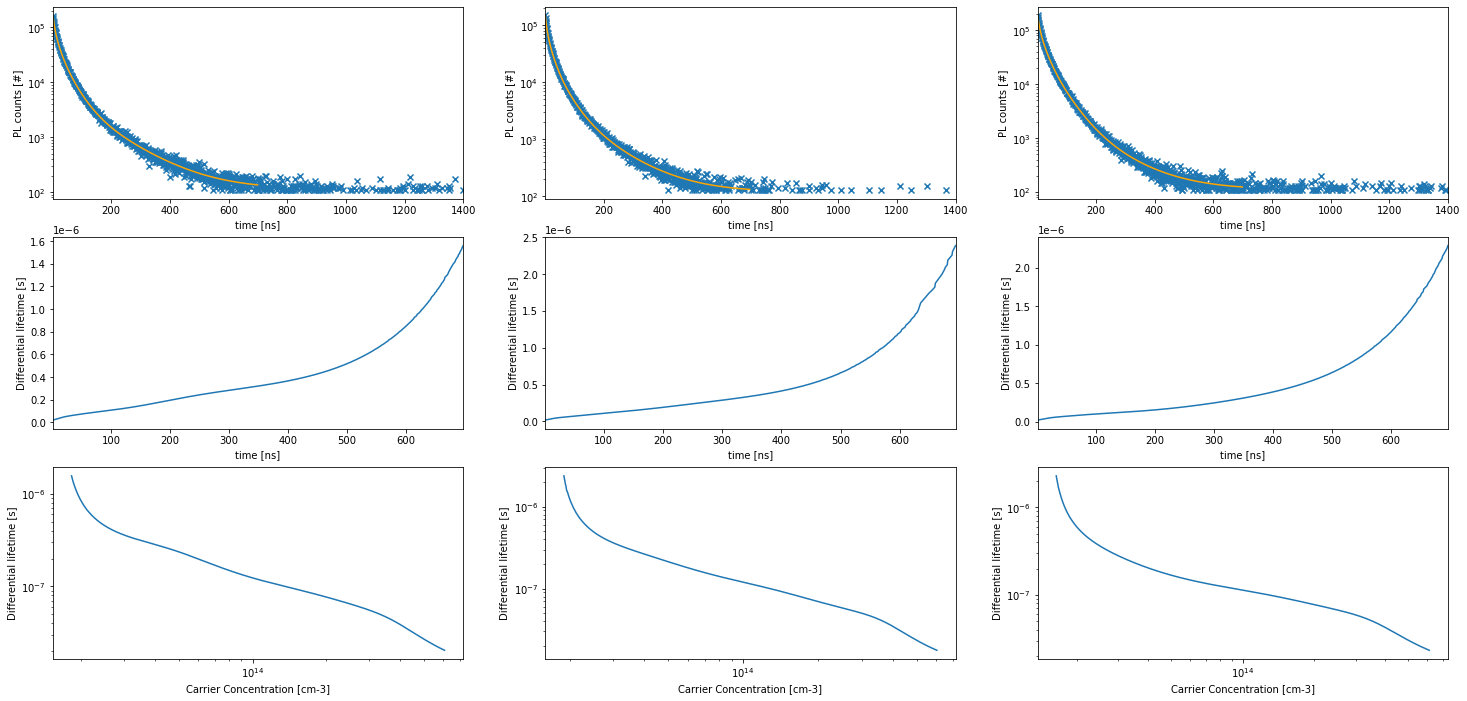

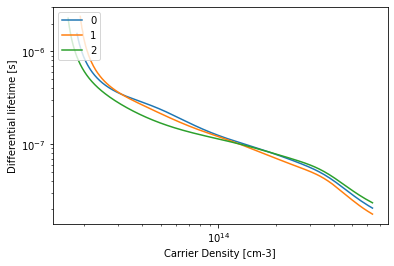

In [60]:
noise_selection = [noise[i] for i in selection]
l = [700, 700, 700] #in ns
start_concentration = [pump_carrierDensity_cm, pump_carrierDensity_cm, pump_carrierDensity_cm]

time, densities, tau_diff = diff.fit_difflifetimes(t[:,selection], TRPL_raw[:,selection], start_concentration, 
                                                                  noise_selection, l2 = l, n_exp = 4)

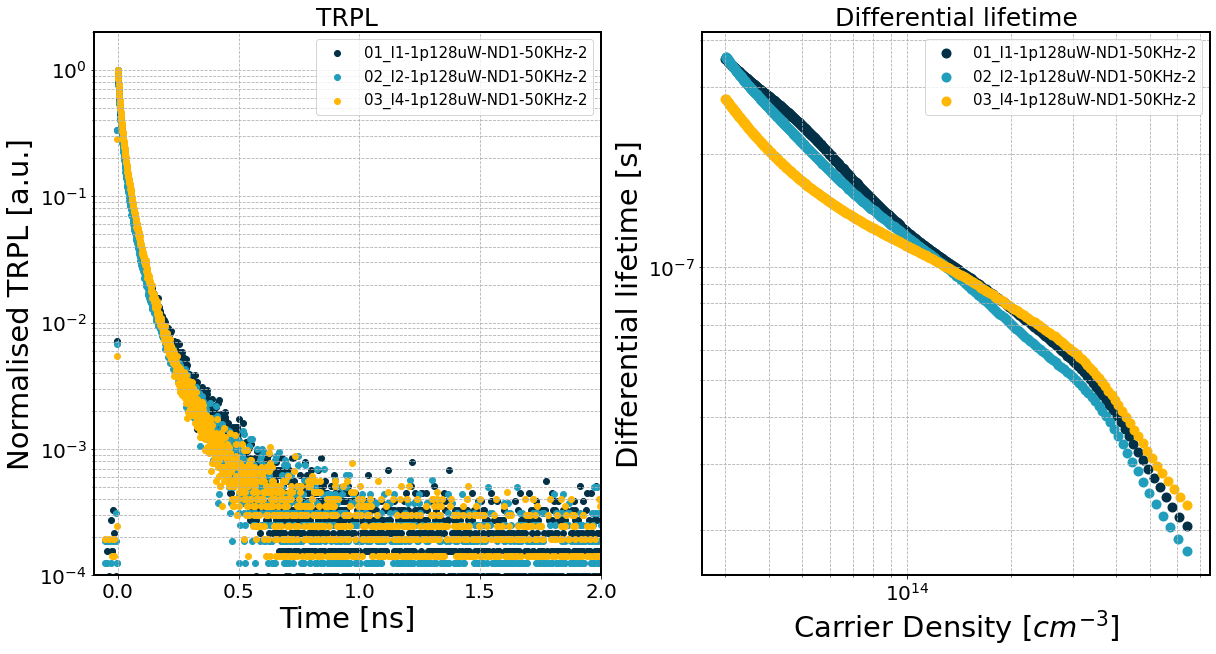

In [73]:
#Plot series
fig, ax = plt.subplots(1,2, figsize = (20,10))
idx_start = 3501
palette = ['#023047', '#126782', '#219EBC', '#8ECAE6', '#FFB703', '#FD9E02', '#FB8500', '#023047', '#126782']

legend = ["1", "2", "3", "4", "5"]

BG = []
for i, (sPL) in enumerate(selection):

    ax[0].scatter(1e6*(t[:,sPL]), TRPL_n[:,sPL], color = palette[2*i], label = files[sPL][:25], alpha = 1)
    ax[1].scatter((densities[i][:-1][densities[i][:-1] > 3e13]), tau_diff[i][(densities[i][:-1] > 3e13)], color = palette[2*i], label = files[sPL][:25], alpha = 1, linewidth = 4.0)

ax[0].set_title('TRPL', fontsize=25)
ax[0].set_xlim([-0.1,2])
ax[0].set_ylim([1e-4,2])
ax[0].set_xscale("linear")
ax[0].set_ylabel("Normalised TRPL [a.u.]", fontsize=axis_fontsize) 
ax[0].set_xlabel("Time [ns]", fontsize=axis_fontsize) 

ax[1].set_title("Differential lifetime", fontsize=25)
ax[1].set_xscale("log")
ax[1].set_ylabel("Differential lifetime [s]", fontsize=axis_fontsize) 
ax[1].set_xlabel("Carrier Density [$cm^{-3}$]", fontsize=axis_fontsize)
#ax[1].set_ylim([2e-8,1e-6])

for i in range(2):
    #ax.set_ylim([1, 1e7])
    ax[i].set_yscale("log")
    
    axis_fontsize = 29
    axisTicks_fontsize = 20
    ax[i].legend(fontsize = 15)
    ax[i].tick_params(axis='x', labelsize=axisTicks_fontsize)
    ax[i].tick_params(axis='y', labelsize=axisTicks_fontsize)
    ax[i].grid(visible = True, which = 'both', linestyle = '--')

    w_frame = 2
    ax[i].spines["bottom"].set_linewidth(w_frame)
    ax[i].spines["top"].set_linewidth(w_frame)
    ax[i].spines["left"].set_linewidth(w_frame)
    ax[i].spines["right"].set_linewidth(w_frame)
    
plt.savefig('./results_TPRL-Bor.png', bbox_inches='tight')